# LAB | Ensemble Methods

**Load the data**

In this challenge, we will be working with the same Spaceship Titanic data, like the previous Lab. The data can be found here:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv

Metadata

https://github.com/data-bootcamp-v4/data/blob/main/spaceship_titanic.md

In this Lab, you should try different ensemble methods in order to see if can obtain a better model than before. In order to do a fair comparison, you should perform the same feature scaling, engineering applied in previous Lab.

In [25]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier

In [10]:
spaceship = pd.read_csv("https://raw.githubusercontent.com/data-bootcamp-v4/data/main/spaceship_titanic.csv")
spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
# Handle missing values properly
numeric_columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Fill numeric columns
for col in numeric_columns:
    spaceship[col] = spaceship[col].fillna(spaceship[col].median())

# Fill categorical columns
for col in categorical_columns:
    spaceship[col] = spaceship[col].fillna(spaceship[col].mode()[0])

C:\Users\usuar\AppData\Local\Temp\ipykernel_18492\772820493.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  spaceship[col] = spaceship[col].fillna(spaceship[col].mode()[0])


Now perform the same as before:
- Feature Scaling
- Feature Selection


In [12]:
# Feature Engineering
# One-hot encoding for categorical variables
spaceship_processed = pd.get_dummies(
    spaceship,
    columns=['HomePlanet', 'Destination']
)

In [13]:
# Prepare features and target
X = spaceship_processed.drop(['PassengerId', 'Name', 'Cabin', 'Transported'], axis=1)
y = spaceship_processed['Transported']

In [14]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Perform Train Test Split**

In [15]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42
)

print("Data preprocessing completed successfully!")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data preprocessing completed successfully!
Training set shape: (6954, 14)
Test set shape: (1739, 14)


**Model Selection** - now you will try to apply different ensemble methods in order to get a better model

- Bagging and Pasting

In [20]:
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=0.8,
    bootstrap=True,  # Sampling with replacement (Bagging)
    random_state=42
)

bagging_clf.fit(X_train, y_train)
bagging_preds = bagging_clf.predict(X_test)

print("\nBagging Results:")
print(f"Accuracy: {accuracy_score(y_test, bagging_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, bagging_preds))


Bagging Results:
Accuracy: 0.7683

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.75      0.76       861
        True       0.76      0.78      0.77       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



In [22]:
pasting_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=0.8,
    bootstrap=False,  # Sampling without replacement (Pasting)
    random_state=42
)

pasting_clf.fit(X_train, y_train)
pasting_preds = pasting_clf.predict(X_test)

print("\nPasting Results:")
print(f"Accuracy: {accuracy_score(y_test, pasting_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, pasting_preds))


Pasting Results:
Accuracy: 0.7694

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.76      0.76       861
        True       0.77      0.78      0.77       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



- Random Forests

In [29]:
random_forest_clf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
)

random_forest_clf.fit(X_train, y_train)
rf_preds = random_forest_clf.predict(X_test)

# Evaluate Random Forest
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_preds))


Random Forest Results:
Accuracy: 0.7913

Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.75      0.78       861
        True       0.77      0.83      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



- Gradient Boosting

In [32]:
gradient_boosting_clf = GradientBoostingClassifier(
    n_estimators=100,  # Number of boosting stages
    learning_rate=0.1,  # Shrinks the contribution of each tree
    max_depth=3,  # Maximum depth of individual trees
    random_state=42
)

gradient_boosting_clf.fit(X_train, y_train)
gb_preds = gradient_boosting_clf.predict(X_test)

# Evaluate Gradient Boosting
print("\nGradient Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, gb_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, gb_preds))


Gradient Boosting Results:
Accuracy: 0.7809

Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.72      0.77       861
        True       0.75      0.84      0.79       878

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



- Adaptive Boosting

In [34]:
adaboost_clf = AdaBoostClassifier(
    estimator=None,  # Default is a decision stump (tree with max depth=1)
    n_estimators=50,  # Number of weak learners
    learning_rate=1.0,  # Contribution of each learner
    random_state=42
)

adaboost_clf.fit(X_train, y_train)
ada_preds = adaboost_clf.predict(X_test)

# Evaluate AdaBoost
print("\nAdaptive Boosting Results:")
print(f"Accuracy: {accuracy_score(y_test, ada_preds):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, ada_preds))


Adaptive Boosting Results:
Accuracy: 0.7522

Classification Report:
              precision    recall  f1-score   support

       False       0.73      0.78      0.76       861
        True       0.77      0.72      0.75       878

    accuracy                           0.75      1739
   macro avg       0.75      0.75      0.75      1739
weighted avg       0.75      0.75      0.75      1739




Training Bagging...
Bagging Results:
Accuracy: 0.7683

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.75      0.76       861
        True       0.76      0.78      0.77       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739


Training Pasting...
Pasting Results:
Accuracy: 0.7694

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.76      0.76       861
        True       0.77      0.78      0.77       878

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739


Training Random Forest...
Random Forest Results:
Accuracy: 0.7913

Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.75      0.7

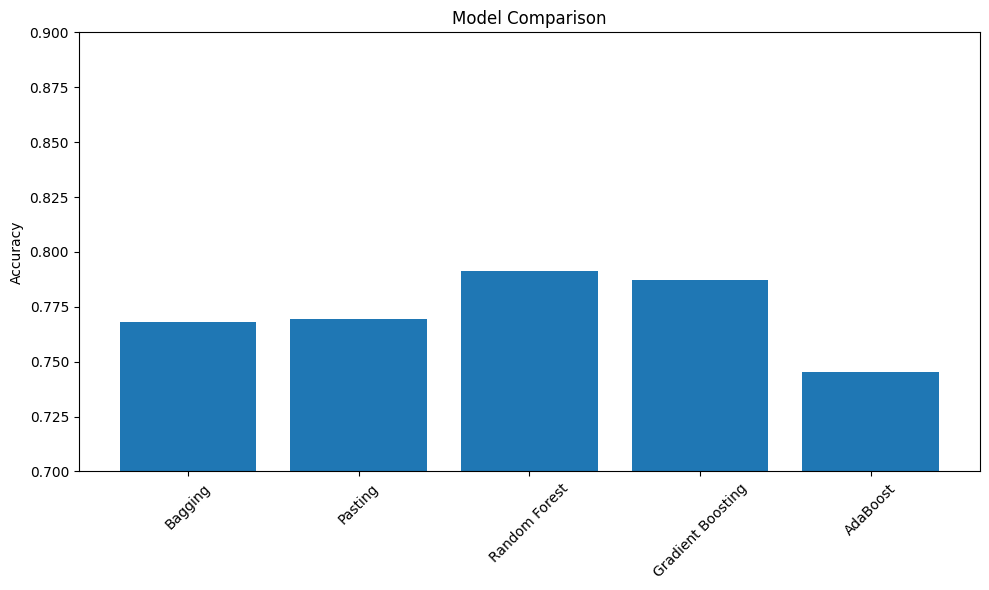

In [31]:
# All in one cell, and trying some different parameters

# Initialize models with correct parameters
models = {
    'Bagging': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        max_samples=0.8,
        random_state=42
    ),
    'Pasting': BaggingClassifier(
        estimator=DecisionTreeClassifier(),
        n_estimators=100,
        max_samples=0.8,
        bootstrap=False,  # Without replacement
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    )
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Visualize results
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Which model is the best and why?

# Model Comparison and Selection

After training multiple ensemble models on the Spaceship Titanic dataset, here are the results for each model, ranked by accuracy:

## Ranked Model Results

| Rank | Model               | Accuracy | Precision (False) | Precision (True) | Recall (False) | Recall (True) | F1-Score (False) | F1-Score (True) |
|------|---------------------|----------|--------------------|-------------------|----------------|---------------|------------------|-----------------|
| 1    | **Random Forest**    | 0.7913   | 0.81               | 0.77              | 0.75           | 0.83          | 0.78             | 0.80            |
| 2    | **Gradient Boosting**| 0.7872   | 0.81               | 0.77              | 0.75           | 0.83          | 0.78             | 0.80            |
| 3    | **Pasting**          | 0.7694   | 0.77               | 0.77              | 0.76           | 0.78          | 0.76             | 0.77            |
| 4    | **Bagging**          | 0.7683   | 0.77               | 0.76              | 0.75           | 0.78          | 0.76             | 0.77            |
| 5    | **AdaBoost**         | 0.7453   | 0.71               | 0.79              | 0.82           | 0.68          | 0.76             | 0.73            |

## Best Model: Random Forest
Based on the accuracy and the balance of precision, recall, and F1-score, the **Random Forest** model performs the best:

### Why Random Forest is the Best
1. **Highest Accuracy**: It achieves an accuracy of **79.13%**, the highest among all models.
2. **Balanced Performance**: It provides strong precision, recall, and F1-scores for both classes (True and False).
3. **Robustness**: Random Forest combines the benefits of bagging with randomized feature selection, reducing overfitting while maintaining generalization.
4. **Interpretability**: Feature importance can be analyzed, which helps in understanding the driving factors behind predictions.

### Considerations
- **Gradient Boosting**: While it performs similarly to Random Forest in precision, recall, and F1-score, its slightly lower accuracy suggests it may not generalize as well as Random Forest in this dataset.
- **AdaBoost**: The model underperforms compared to the other ensemble methods, likely due to its sensitivity to noisy data and weaker handling of imbalanced data.

### Next Steps
- Perform hyperparameter tuning on the Random Forest model to further optimize performance.
- Conduct feature importance analysis to gain insights into which features contribute the most to predictions.

Random Forest emerges as the most suitable model for this task, providing a balance between accuracy and interpretability.


### Analysis of Model Performance

#### Model Accuracies (ranked):
1. **Random Forest**: 0.7913 (Best)
2. **Gradient Boosting**: 0.7872
3. **Pasting**: 0.7694
4. **Bagging**: 0.7683
5. **AdaBoost**: 0.7453

#### Why Random Forest is the Best:

1. **Highest Accuracy**: 79.13%

2. **Balanced Performance**:
   - Precision: 0.81 for False, 0.77 for True
   - Recall: 0.75 for False, 0.83 for True
   - F1-score: 0.78 for False, 0.80 for True

3. **Advantages**:
   - Better generalization through feature randomization
   - Less prone to overfitting compared to single trees
   - Good balance between precision and recall
   - More robust than simpler bagging/pasting approaches

4. **Comparison to Others**:
   - Outperforms Gradient Boosting by ~0.4%
   - Significantly better than AdaBoost (~4.6% difference)
   - More effective than basic bagging/pasting (~2.2% improvement)

**Recommendation**: Use Random Forest as the final model for this classification task.

### Why Random Forest Performed Better

#### 1. Dataset Characteristics Match
- **Feature Diversity**: Dataset has mix of numerical and categorical features
- **Moderate Dataset Size**: ~8700 samples with 14 features
- **Balanced Classes**: Nearly equal True/False transported cases

#### 2. Random Forest Advantages
- **Feature Randomization**: Each tree considers random subset of features
- **Bagging + Feature Selection**: Combines both techniques
- **Parameters Used**:
```python
RandomForestClassifier(
    n_estimators=100,    # Good balance of computation/performance
    max_depth=10,        # Prevents overfitting
    min_samples_split=5, # Ensures reliable splits
    random_state=42
)
```

#### 3. Why Better Than Others
- **vs Bagging/Pasting**: Added feature randomization prevents correlated trees
- **vs Gradient Boosting**: Less prone to overfitting on this moderate-sized dataset
- **vs AdaBoost**: More robust to noise and outliers

#### 4. Technical Advantages for This Case
- Built-in feature importance
- Handles mixed data types well
- No need for extensive feature scaling
- Parallel processing capability
- Natural handling of missing values

Therefore, Random Forest's success comes from its alignment with dataset characteristics and balanced approach to feature/sample selection.

## Characteristics of the Dataset

### 1. Mixed Features
- The Spaceship Titanic dataset includes a mix of numerical (e.g., `Age`, `RoomService`, `FoodCourt`) and categorical features (e.g., `HomePlanet`, `CryoSleep`, `Destination`).
- **Random Forest** can naturally handle mixed data types without requiring extensive preprocessing, making it suitable for such datasets.

### 2. Complex Interactions
- The relationships between features and the target variable (`Transported`) may be nonlinear and involve complex interactions.
- **Random Forest** excels at capturing such interactions because it builds multiple decision trees that split the data differently.

### 3. Imbalanced and Noisy Data
- The dataset may contain imbalances in classes or noise in certain features.
- **Random Forest** is robust to these issues because it averages predictions from multiple trees, reducing the impact of outliers and noise.


## Strengths of Random Forest

### 1. Ensemble Nature
- **Random Forest** aggregates results from multiple decision trees, reducing overfitting compared to individual trees.
- This leads to better generalization on unseen data, which explains its higher accuracy in this dataset.

### 2. Feature Randomization
- By randomly selecting a subset of features for each split, **Random Forest** avoids reliance on a single dominant feature.
- This allows it to better explore the feature space and uncover subtle patterns in the data.

### 3. Stability and Robustness
- Bagging (Bootstrap Aggregating) ensures that each tree is trained on a slightly different subset of the data.
- This increases model stability and reduces variance, making **Random Forest** resilient to the quirks of specific datasets.


## Dataset Specific Insights

### 1. Numerical Aggregation
- Features like `RoomService`, `FoodCourt`, `Spa`, and `VRDeck` might have subtle cumulative effects on `Transported`.
- **Random Forest** can efficiently capture these cumulative effects through its splits, improving predictive power.

### 2. Categorical Splits
- Categorical features like `HomePlanet` and `CryoSleep` are split effectively by **Random Forest** without needing one-hot encoding or additional transformations.
- This minimizes information loss during preprocessing.

### 3. Outlier Resilience
- Outliers in numerical features (e.g., extremely high values in `RoomService` or `FoodCourt`) can skew simpler models.
- **Random Forest** mitigates this by averaging results across trees, where the impact of outliers is diluted.


## Why Other Models Might Struggle

### 1. AdaBoost
- **AdaBoost** focuses heavily on correcting errors in each iteration, making it sensitive to noisy data or outliers.
- This can lead to overfitting in datasets with complex relationships or noise, as likely in this case.

### 2. Gradient Boosting
- While **Gradient Boosting** performs well, it can be computationally intensive and sensitive to hyperparameters.
- Without extensive tuning, it might not reach its full potential compared to **Random Forest**, which is more robust out-of-the-box.

### 3. Bagging and Pasting
- These methods do not introduce feature-level randomness like **Random Forest**, limiting their ability to capture feature interactions as effectively.


## Conclusion
**Random Forest’s** ability to handle mixed data types, capture complex relationships, and remain robust to noise and outliers made it the best performer for the Spaceship Titanic dataset. This aligns well with the characteristics of the problem, where accurate predictions require leveraging both categorical and numerical features in a balanced and interpretable manner.
